In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json

from sklearn.metrics import adjusted_rand_score
from more_itertools import flatten
from scipy.special import gammaln, digamma
from scipy.stats import gamma

### Function for data extraction

In [11]:
def data_and_param_extract(idx, N_runs):
    ## LOAD RELEVANT DATA
    base_path = "analyses/simulation_studies/simulation_output/simulation_study_1/"

    output_dict = dict()

    ## alpha
    alpha_list = []
    for j in range(N_runs):
        file_path = base_path + f"alpha/alpha_store_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        alpha_list.append(data)

    ## beta
    beta_list = []
    for j in range(N_runs):
        file_path = base_path + f"beta/beta_store_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        beta_list.append(data)

    ## tau
    tau_list = []
    for j in range(N_runs):
        file_path = base_path + f"tau/tau_store_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        tau_list.append(data)

    ## group changes
    group_changes_list = []
    for j in range(N_runs):
        file_path = base_path + f"group_changes/group_changes_list_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        group_changes_list.append(data)

    
    ## group memberships
    group_memberships_list = []
    for j in range(N_runs):
        file_path = base_path + f"group_memberships/group_memberships_{idx}_{j}.pkl"
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        f.close()
        group_memberships_list.append(data)

    output_dict['alpha'] = alpha_list
    output_dict['beta'] = beta_list
    output_dict['group_changes'] = group_changes_list
    output_dict['group_memberships'] = group_memberships_list
    output_dict['tau'] = tau_list

    ## EXTRACT THE RELEVANT SIMULATION PARAMETERS
    param_path = "analyses/simulation_studies/simulation_parameters/simulation_study_1"
    with open(param_path + '/sim_params_simulation_study_1.json', 'r') as file:
        sim_params = json.load(file)
        sim_params_curr = sim_params[idx]

    output_dict['lam_matrix'] = np.array([[2.0, 1.0], [0.3, 8.0]])
    output_dict['rho_matrix'] = np.array([[1, 1], [1, 1]])
    output_dict['num_nodes'] = 500
    output_dict['num_groups'] = 2
    output_dict['group_props'] = np.array([0.6, 0.4])
    output_dict['n_cavi'] = 3
    output_dict['int_length'] = 0.1
    output_dict['T_max'] = 5
    output_dict['delta'] = float(sim_params_curr[0])
    output_dict['prop_swap'] = float(sim_params_curr[1])    

    ## CONSTRUCT TRUE GROUP LABELS
    group_sizes = (output_dict['group_props'] * output_dict['num_nodes']).astype('int')
    output_dict['group_sizes'] = group_sizes
    missing_nodes = output_dict['num_nodes'] - group_sizes.sum()
    if missing_nodes != 0:
        if np.sum(np.where(group_sizes == 0)) != 0:
            group_sizes[np.where(group_sizes == 0)] = missing_nodes
        else:
            group_sizes[-1] += missing_nodes
    init_groups = np.array(
                list(flatten([[i]*j for i,j in enumerate(group_sizes)]))
                )
    change_groups = init_groups.copy()
    change_groups[:int(group_sizes[0] * output_dict['prop_swap'])] = (
        (1 - change_groups[:int(group_sizes[0] * output_dict['prop_swap'])])
    )

    output_dict['groups_in_regions'] = [init_groups, change_groups]

    return output_dict


### Define macros

In [7]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

colours = [(208/255, 28/255, 139/255),
           (241/255, 182/255, 218/255),
           (184/255, 225/255, 134/255),
           (77/255, 172/255, 38/255)]

### Compute adjusted rand index


In [70]:
B1 = 10

df_ARI = pd.DataFrame(columns=['delta', 'prop_swap', 'ARI'], index=range(12))

for sim in range(14):
    data_dict = data_and_param_extract(sim, 50)
    df_ARI.loc[sim, ['delta', 'prop_swap']] = (
        [data_dict['delta'], data_dict['prop_swap']]
    )  
    # print(f"New group prop: {data_dict['new_group_prop']}")
    group_memberships = data_dict['group_memberships']
    _ARI_list_time = []
    for run in range(50):
        _ARI_list_run = []
        group_memberships_curr = group_memberships[run]

        # Up to first change
        true_groups = data_dict['groups_in_regions'][0]
        for time_step in range(int(1 / 0.1) + 1 - B1, int(3 / 0.1) + 1 - B1):
            _pred_groups = group_memberships_curr[time_step,:]
            _ARI = adjusted_rand_score(true_groups, _pred_groups)
            _ARI_list_run.append(_ARI)
        
        # After change
        true_groups = data_dict['groups_in_regions'][1]
        for time_step in range(int(3 / 0.1) + 1 - B1, int(5 / 0.1) + 1 - B1):
            _pred_groups = group_memberships_curr[time_step,:]
            _ARI = adjusted_rand_score(true_groups, _pred_groups)
            _ARI_list_run.append(_ARI)

        _ARI_list_time.append([l for l in _ARI_list_run])
    df_ARI.loc[sim, 'ARI'] = _ARI_list_time

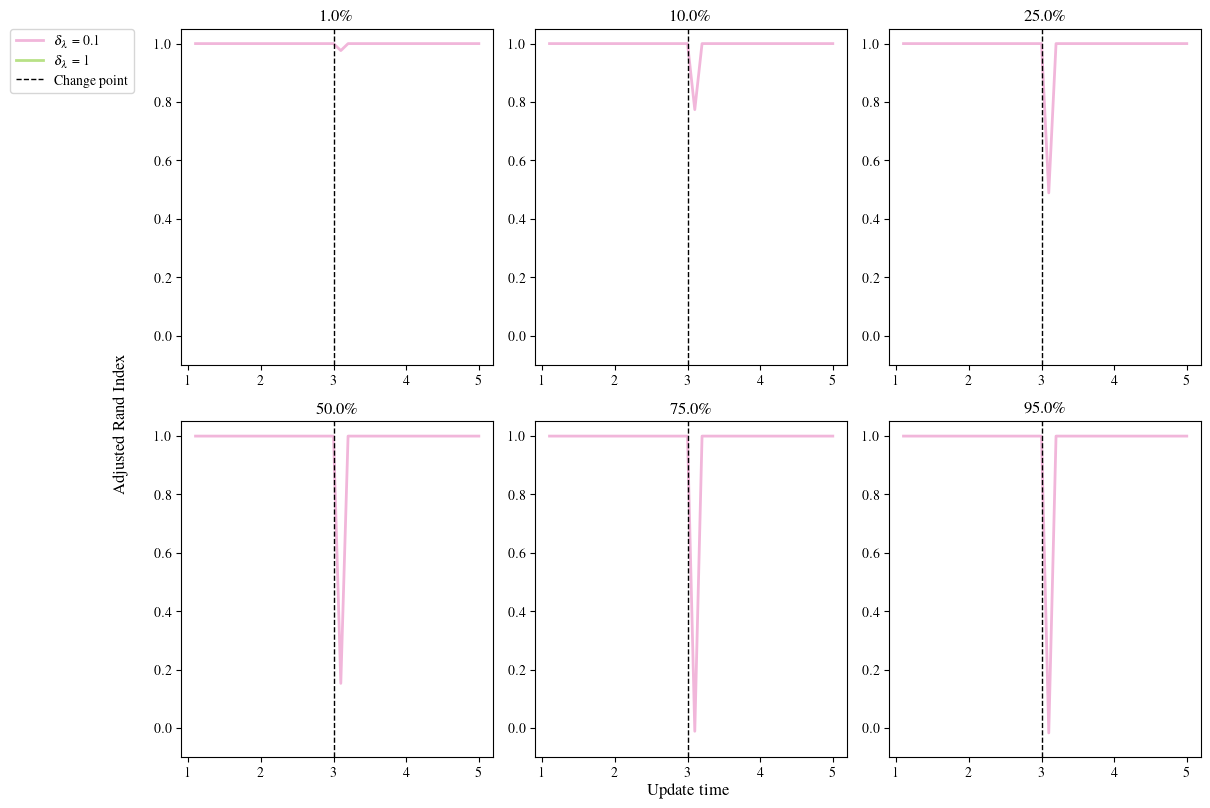

In [77]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

legend_handles, legend_labels = [], []

row_counter = -1
prop_swap = [0.01, 0.1, 0.25, 0.5, 0.75, 0.95]
group_1_count = -1
for i in range(2):
    for j in range(3):
        group_1_count += 1
        for delta in [0.1]:
            index = df_ARI[
                        (df_ARI['delta'] == delta)
                        &
                        (df_ARI['prop_swap'] == prop_swap[group_1_count])
                        ].index[0]
            ARI_data = df_ARI.loc[index, ['ARI']]
            temp_array = np.array([np.array(entry) for entry in ARI_data['ARI']])
            mean_ARI = temp_array.mean(axis=0)
            if delta == 0.1:
                line1 = axs[i,j].plot(np.arange(1 + 0.1, 5 + 0.1, 0.1), mean_ARI, color = colours[1],
                              linewidth=2)
                axs[i,j].set_title(fr"{prop_swap[group_1_count] * 100}\%", fontsize=12)
            if delta == 1:
                line2 = axs[i,j].plot(np.arange(1 + 0.1, 5 + 0.1, 0.1), mean_ARI, color = colours[2],
                              linewidth=2)
                axs[i,j].set_title(fr"{prop_swap[group_1_count] * 100}\%", fontsize=12)
            line3 = axs[i,j].axvline(x=3, linestyle='--', linewidth=1, color='black')
        if (i == 0) & (j == 0):
            legend_handles.append(line1[0])
            legend_labels.append(r"$\delta_\lambda$ = 0.1")
            legend_handles.append(line2[0])
            legend_labels.append(r"$\delta_\lambda$ = 1")
            legend_handles.append(line3)
            legend_labels.append("Change point")

        axs[i,j].set_ylim([-0.1,1.05])

fig.text(0.56, 0, 'Update time', ha='center', fontsize=12)
fig.text(0.087, 0.38, 'Adjusted Rand Index', ha='center', rotation='vertical', fontsize=12)

# Add legend to the top left subplot
axs[0, 0].legend(legend_handles, legend_labels, loc='upper left', 
                 bbox_to_anchor=(-0.55, 1.0), borderaxespad=0.0)
plt.tight_layout()
plt.savefig("analyses/simulation_studies/simulation_output/simulation_study_1/plots/ARI_time.pdf",
            bbox_inches='tight')

### Group proportions

In [176]:
df_group_prop = pd.DataFrame(columns=['delta', 'prop_swap', 'pred_group_1_props',
                                      'true_group_prop'], index=range(12))

for sim in range(14):
    data_dict = data_and_param_extract(sim, 50)
    true_group_prop = [x.mean() for x in data_dict['groups_in_regions']] 
    df_group_prop.loc[sim, ['delta', 'prop_swap', 'true_group_prop']] = (
        [data_dict['delta'], data_dict['prop_swap'], true_group_prop]
    )  
    pred_group_1_prop_sim = []
    for run in range(50):
        group_memberships = data_dict['group_memberships']
        pred_group_1_prop_time = group_memberships[run].mean(axis=1)

        # Adjust for labelling differences
        group_1_dist = abs(pred_group_1_prop_time[0] - 0.6)
        group_2_dist = abs(pred_group_1_prop_time[0] - 0.4)
        group_1_dist_max = group_1_dist > group_2_dist
        
        if group_1_dist_max:
            pred_group_1_prop_time = 1 - pred_group_1_prop_time
        pred_group_1_prop_sim.append(pred_group_1_prop_time)
    df_group_prop.loc[sim, 'pred_group_1_props'] = np.stack(pred_group_1_prop_sim).mean(axis=0)
    

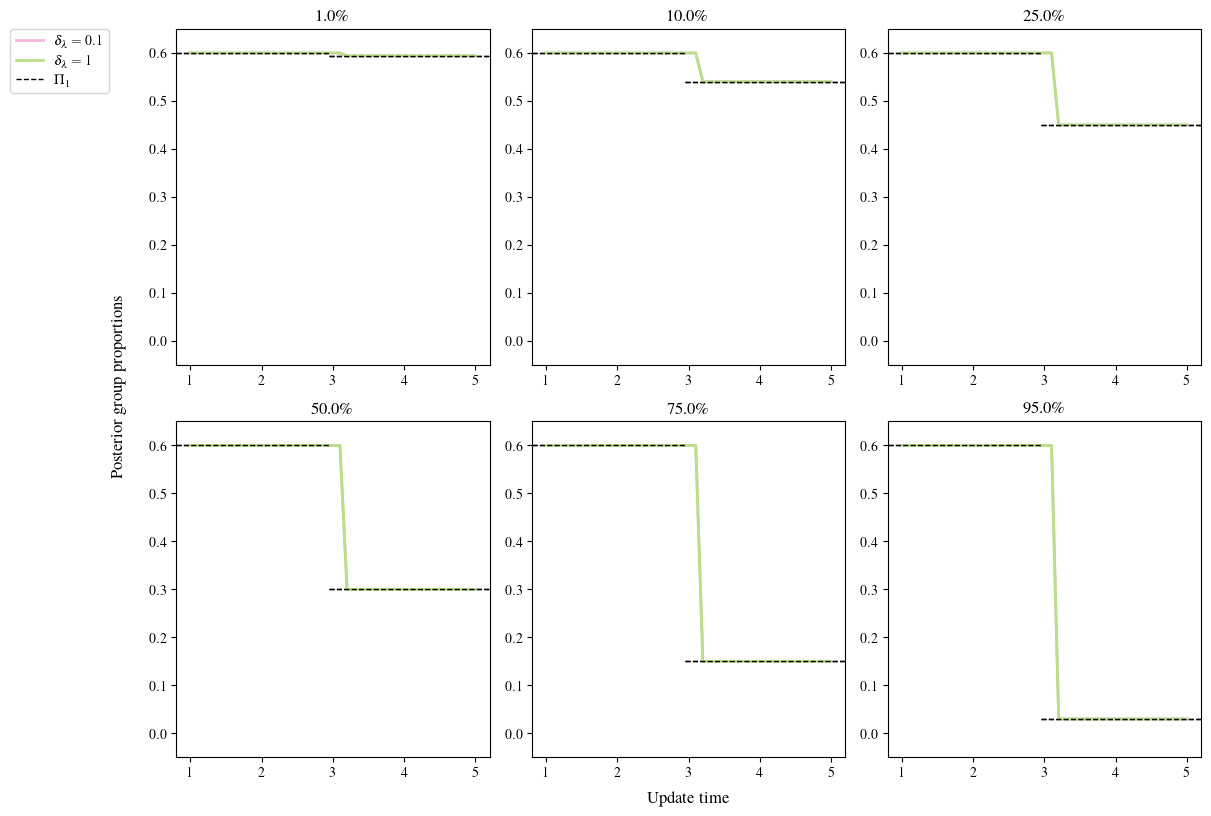

In [193]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

row_counter = -1
group_1_props = [0.01, 0.1, 0.25, 0.5, 0.75, 0.95]
group_1_count = -1

legend_handles, legend_labels = [], []

for i in range(2):
    for j in range(3):
        group_1_count += 1
        for delta in [0.1, 1]:
            index = df_group_prop[
                        (df_group_prop['delta'] == delta)
                        &
                        (df_group_prop['prop_swap'] == group_1_props[group_1_count])
                        ].index[0]
            pred_group_1_props = df_group_prop.loc[index, 'pred_group_1_props']
            if delta == 0.1:
                line1 = axs[i,j].plot(np.arange(1, 5 + 0.1, 0.1), pred_group_1_props, 
                              color = colours[1], linewidth=2)
                axs[i,j].set_title(fr"{group_1_props[group_1_count] * 100}\%", fontsize=12)
            if delta == 1:
                line2 = axs[i,j].plot(np.arange(1, 5 + 0.1, 0.1), pred_group_1_props, 
                              color = colours[2], linewidth=2)
                axs[i,j].set_title(fr"{group_1_props[group_1_count] * 100}\%", fontsize=12)
                
            # Plot true group props
            x_change_prop = (int(3 / 0.1) - int(1 / 0.1)) / len(np.arange(1, 5 + 0.1, 0.1))
            line3 = axs[i,j].axhline((1 - df_group_prop.loc[index, 'true_group_prop'][0]), 
                             xmin=0, xmax=x_change_prop,
                            linewidth=1, linestyle='--', color='black');
            axs[i,j].axhline((1 - df_group_prop.loc[index, 'true_group_prop'][1]), 
                             xmin=x_change_prop, xmax=1,
                            linewidth=1, linestyle='--', color='black');
        if (i == 0) & (j == 0):
            legend_handles.append(line1[0])
            legend_labels.append(r"$\delta_\lambda = 0.1$")
            legend_handles.append(line2[0])
            legend_labels.append(r"$\delta_\lambda = 1$")
            legend_handles.append(line3)
            legend_labels.append(r"$\Pi_1$")
        
        axs[i,j].set_ylim([-0.05, 0.65])

fig.text(0.56, -0.01, 'Update time', ha='center', fontsize=12)
fig.text(0.085, 0.4, 'Posterior group proportions', ha='center', 
         rotation='vertical', fontsize=12)

# Add legend to the top left subplot
axs[0, 0].legend(legend_handles, legend_labels, loc='upper left', 
                 bbox_to_anchor=(-0.53, 1.0), borderaxespad=0.0)

plt.tight_layout()

plt.savefig("analyses/simulation_studies/simulation_output/simulation_study_1/plots/group_props.pdf",
            bbox_inches='tight')